In [ ]:
import pandas as pd 
import nltk
import numpy as np
#load inthe NTLK stopwords to remove articles, preposition and other words that are not actionable
from nltk.corpus import stopwords
# This allows to create individual objects from a bog of words
from nltk.tokenize import word_tokenize, sent_tokenize
# Lemmatizer helps to reduce words to the base form
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from google.colab import drive 
drive.mount('/content/gdrive')
df=pd.read_csv('gdrive/My Drive/summer.csv')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Mounted at /content/gdrive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def process_sentence(sentence):
    new_tokens = word_tokenize(sentence)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens = [t for t in new_tokens if t not in stopwords.words('english')]
    new_tokens = [t for t in new_tokens if t.isalpha()]
    lemmatizer = WordNetLemmatizer()
    new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
    return " ".join(new_tokens)

In [ ]:
titles = df['title_orig'].tolist()
tokens = [process_sentence(t) for t in titles]
df['title_pre'] = tokens

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['title_pre'])

In [ ]:
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
tfidf = pd.DataFrame(denselist, columns=feature_names)
tfidf_list = tfidf.values

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from PIL import Image
from io import BytesIO
import urllib.request
pd.set_option('display.max_colwidth', None)

# load the image with urllib + BytesIO
pixel = [np.array(Image.open(BytesIO(urllib.request.urlopen(url).read())).resize((224,224),Image.ANTIALIAS)) for url in df["product_picture"]]
df["image_pixel"] = pixel

In [ ]:
def main_color(s):
  main_color = {"red":"red", "white":"white", "pink":"pink", "yellow":"yellow", "green":"green", "blue":"blue", "wine":"red", "burgundy":"red", "black":"black", "navy":"navy", "orange":"orange", 
  "rose":"pink", "gray":"gray", "grey":"gray", "purple":"purple", "violet":"purple", "army":"green", "leopard":"orange", "ivory":"white", 
  "brown":"brown", "coffee":"brown", "camel":"beige", "tan":"brown", "nude":"beige", "khaki":"khaki", "apricot":"yellow", "camouflage":"green", "jasper":"red"}  # ordered by importance
  for key, value in main_color.items():
    if key in s:
      return value
  return "others"
product_color = df["product_color"]
product_color = [s.lower() if type(s) is str else 'nan' for s in product_color]
product_color = [main_color(s) for s in product_color]

In [ ]:
from matplotlib import colors
avg_list = []
for s in product_color:
  if s != "others":
    avg_list.append(np.array(colors.to_rgb(s)))
average_color = tuple(np.array(avg_list).mean(0))
product_color = [average_color if s == "others" else colors.to_rgb(s) for s in product_color]
df['product_color_rgb'] = [np.array(t) for t in product_color]

In [ ]:
df['log_price'] = [np.log(p) for p in df["price"]]
df['log_retail_price'] = [np.log(p) for p in df["retail_price"]]
df["discount_ratio"] = [df["price"][i]/df["retail_price"][i] for i in range(len(df["price"]))]
df['urgent'] = [1 if s == "Quantité limitée !" else 0 for s in df["urgency_text"]]
label = [1 if sales > 400 else 0 for sales in df["units_sold"]]
df['high_sale'] = label
df["tfidf"] = [v for v in tfidf_list]

In [ ]:
df = df[["tfidf", "image_pixel", "log_price", "log_retail_price", "discount_ratio", "uses_ad_boosts", "badges_count", "badge_local_product", "badge_product_quality", "badge_fast_shipping", "shipping_option_price", "shipping_is_express", "countries_shipped_to", "inventory_total", "product_color_rgb", "urgent", "high_sale"]]
rgb = df["product_color_rgb"]
rgb = np.stack(rgb.values, axis=0)
for i in range(3):
  df["product_color_rgb"+str(i)] = rgb[:,i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
X = df[df.columns.difference(["high_sale", "product_color_rgb"])]
y = df["high_sale"]

In [ ]:
from sklearn.model_selection import train_test_split
# Split into 0.75:0.125:0.125
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=1)
# X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.14286, random_state=42)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of dev examples = " + str(X_dev.shape[0]))
# print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_dev shape: " + str(X_dev.shape))
print ("Y_dev shape: " + str(y_dev.shape))
# print ("X_test shape: " + str(X_test.shape))
# print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1258
number of dev examples = 315
X_train shape: (1258, 18)
Y_train shape: (1258,)
X_dev shape: (315, 18)
Y_dev shape: (315,)


In [ ]:
np.sum(np.array(y_dev))

180

In [ ]:
import tensorflow as tf
def get_image_text_feature(df):
  return np.stack(df["image_pixel"].to_numpy(), axis=0), tf.expand_dims(np.stack(df["tfidf"].to_numpy(), axis=0), axis=-1), df[df.columns.difference(["image_pixel", "tfidf"])]
X_train_image, X_train_text, X_train_feature = get_image_text_feature(X_train)
# X_test_image, X_test_text, X_test_feature = get_image_text_feature(X_test)
X_dev_image, X_dev_text, X_dev_feature = get_image_text_feature(X_dev)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
import cv2
from os import listdir
from os.path import isfile, join
import string
import re
import nltk
from keras import layers
from keras import Input
from keras.models import Model
from keras import models
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.regularizers import l2
image_input = Input(shape=(224, 224, 3), name='image')
vgg16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
vgg16.trainable = False
x = vgg16(image_input)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)

In [ ]:
feature_input = Input(shape=(16,), name='feature')
concatenated = layers.concatenate([x, feature_input], axis=-1)
concatenated = tf.keras.layers.Dense(64, activation='relu')(concatenated)
concatenated = tf.keras.layers.BatchNormalization()(concatenated)
concatenated = tf.keras.layers.Dense(32, activation='relu')(concatenated)
concatenated = tf.keras.layers.BatchNormalization()(concatenated)
output = layers.Dense(1, activation='sigmoid')(concatenated)
model = Model([image_input, feature_input], output)
# Adam Optimizer Adaptive Learning Rate
# opt = tf.keras.optimizers.Adam(learning_rate = 0.01, decay = 0.2)
opt = tf.keras.optimizers.Adam()
model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['image[0][0]']                  
                                                                                                  
 flatten_2 (Flatten)            (None, 25088)        0           ['vgg16[0][0]']                  
                                                                                                  
 dense_10 (Dense)               (None, 1024)         25691136    ['flatten_2[0][0]']        

In [ ]:
EPOCHS = 150
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    mode='max',
    verbose=1,
    patience=6
)
# history = model.fit(
#     [X_train_image, X_train_text, X_train_feature],
#     y_train,
#     epochs=EPOCHS,
#     validation_data=([X_dev_image, X_dev_text, X_dev_feature], y_dev),
#     batch_size = 32,
#     callbacks=[early_stopping])
history = model.fit(
    [X_train_image, X_train_feature],
    y_train,
    epochs=EPOCHS,
    validation_data=([X_dev_image, X_dev_feature], y_dev),
    batch_size = 16)

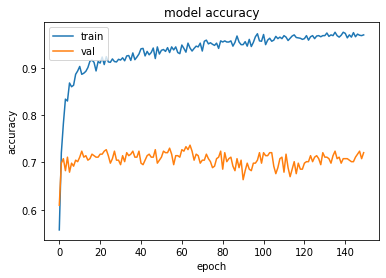

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

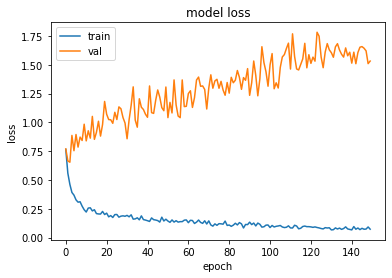

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()